In [105]:
###########################################################################################
# Прогнозирование временных рядов с помощью библиотеки "prophet"
# 
# Прогноз аудитории по количеству бесплатных установок приложения по данным из СУБД ClickHouse
#
# Справка по библиотеке "prophet": help(Prophet)
###########################################################################################

In [106]:
# Импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import pandahouse as ph
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import os
import sys
import warnings
from datetime import date
import holidays
from fbprophet import Prophet
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [107]:
# Объявляем параметры подключения к СУБД ClickHouse

connection = dict(database='installs',
                  host='https://clickhouse.marketplace.retail',
                  user='admin',
                  password='256e2b0c9c')

In [108]:
# Для прогнозирования временного ряда нам необходимы: 1) дата со временем, 2) метрика прогнозирования
# Считываем данные (первый столбец - даты (ds), второй - уникальные пользователи (y))
# Используем в запросе к ClickHouse источник с самым большим количеством бесплатных установок приложения

query = """
SELECT 
    ds,
    uniqExact(DeviceID) AS y
FROM test.installs
WHERE 
        Source = 'Source_27'
    AND InstallCost = 0
GROUP BY CAST(InstallationDate AS Date)  AS ds
ORDER BY ds ASC
"""
df = ph.read_clickhouse(query, connection = connection)
df['ds'] = pd.to_datetime(df.ds)
df

,ds,y
0,2019-01-01,26243
1,2019-01-02,31303
2,2019-01-03,34017
3,2019-01-04,33807
4,2019-01-05,33925
...,...,...
272,2019-09-30,19028
273,2019-10-01,19176
274,2019-10-02,18926
275,2019-10-03,18373


In [109]:
# Задаём в нашу модель календарные праздники
# Праздники здесь необходимы для поиска корреляции между календарными праздниками и происходящем в нашем мобильном сервисе

holidays_dict = holidays.RU(years = (2015, 2016, 2017, 2018, 2019, 2020, 2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient = 'index').reset_index()
df_holidays = df_holidays.rename({'index': 'ds', 0: 'holiday'}, axis = 'columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by = ['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.tail()

,ds,holiday
93,2021-03-08,День женщин
94,2021-05-01,Праздник Весны и Труда
95,2021-05-09,День Победы
96,2021-06-12,День России
97,2021-11-04,День народного единства


In [110]:
# Проверим нашу предсказательную модель на последних 30 днях прогноза

predictions = 30

# Отсекаем из обучающей выборки последние N точек, чтобы измерить на них качество модели

train_df = df[:-predictions]

In [111]:
# Настраиваем модель – с учетом календарных праздников и временной сезонности
# 
# Непосредственно для наших данных:
#    daily_seasonality = False - сезонность внутри дня (когда данные представлены почасово/поминутно/посекундно)
#    yearly_seasonality = False - из-за небольшого количества данных по годам

m = Prophet(holidays = df_holidays, daily_seasonality = False, weekly_seasonality = True, yearly_seasonality = False)
m.fit(train_df)

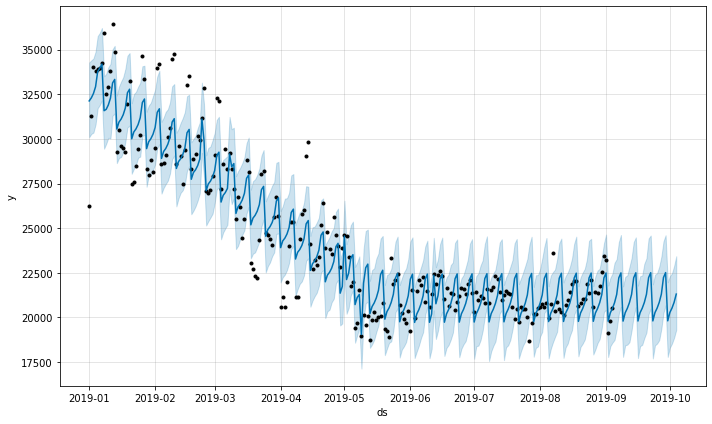

In [112]:
# Делаем прогноз на 30 дней и строим по ним график
#
# Здесь на графике:
#    точки - фактические значения,
#    линия - предсказание

future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)
m.plot(forecast);

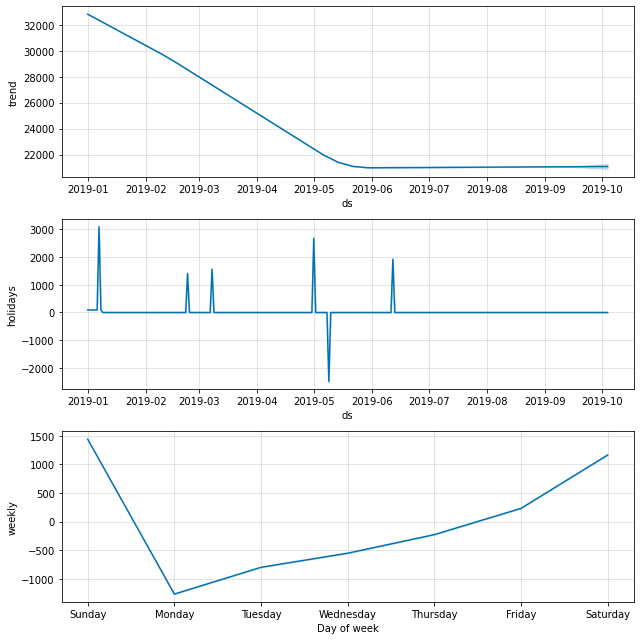

In [113]:
# Смотрим на сезонности прогноза (какие компоненты были найдены в наших данных)

# Представленные графики ниже по порядку:
#    Линия тренда,
#    Влияние праздников,
#    Недельная сезонность (внутри недели) - здесь видно, что к выходным дням у нас происходит рост

m.plot_components(forecast);

In [114]:
# Строим график с границами прогноза

init_notebook_mode(connected = True)

iplot([
    go.Scatter(x = df['ds'], y = df['y'], name = 'Фактические данные'),
    go.Scatter(x = forecast['ds'], y = forecast['yhat'], name = 'Прогноз'),
    go.Scatter(x = forecast['ds'], y = forecast['yhat_upper'], fill = 'tonexty', mode = 'none', name = 'Верхняя граница'),
    go.Scatter(x = forecast['ds'], y = forecast['yhat_lower'], fill = 'tonexty', mode = 'none', name = 'Нижняя граница'),
    go.Scatter(x = forecast['ds'], y = forecast['trend'], name = 'Линия тренда')
])

In [115]:
# Оцениваем ошибки модели

# Из полученного прогноза видно, что средняя абсолютная ошибка составляет - "1080 установок" в среднем (или же "5,6%")

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', round(np.mean(abs(cmp_df[-predictions:]['p'])), 1),'%')
print('MAE (средняя абсолютная ошибка [в единицах предсказания]) – ', round(np.mean(abs(cmp_df[-predictions:]['e'])), 0))

MAPE (средняя абсолютная ошибка в процентах) –  5.6 %
MAE (средняя абсолютная ошибка [в единицах предсказания]) –  1080.0


In [116]:
# Прогнозируем на полный календарный период (указываем количество дней)

prediction_days = 90
final_train_df = df
f = Prophet(holidays = df_holidays, daily_seasonality = False, weekly_seasonality = True, yearly_seasonality = False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods = prediction_days)
final_forecast = f.predict(final_future)

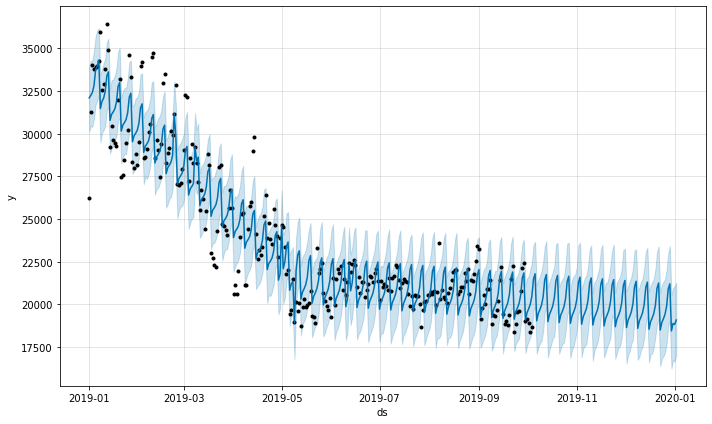

In [117]:
# Смотрим прогноз на полный временной период

f.plot(final_forecast);

In [118]:
# Строим график с границами прогноза на полном временном периоде

iplot([
    go.Scatter(x = df['ds'], y = df['y'], name = 'Фактические данные'),
    go.Scatter(x = final_forecast['ds'], y = final_forecast['yhat'], name = 'Прогноз'),
    go.Scatter(x = final_forecast['ds'], y = final_forecast['yhat_upper'], fill = 'tonexty', mode = 'none', name = 'Верхняя граница'),
    go.Scatter(x = final_forecast['ds'], y = final_forecast['yhat_lower'], fill = 'tonexty', mode = 'none', name = 'Нижняя граница'),
    go.Scatter(x = final_forecast['ds'], y = final_forecast['trend'], name = 'Линия тренда')
])

In [119]:
# Выгружаем наш прогноз в файл MS Excel. 
# Спрогнозированное значение находятся в столбце - "yhat"

final_forecast.to_excel("./forecast_data.xlsx", sheet_name = 'Data', index = False, encoding = "cp1251")

In [120]:
final_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,Православное Рождество,Православное Рождество_lower,Православное Рождество_upper,Праздник Весны и Труда,Праздник Весны и Труда_lower,Праздник Весны и Труда_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,33184.768856,30121.596027,33973.171924,33184.768856,33184.768856,-1078.909028,-1078.909028,-1078.909028,-283.872542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32105.859828
1,2019-01-02,33095.603159,30462.203737,34261.562664,33095.603159,33095.603159,-849.031396,-849.031396,-849.031396,-283.872542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32246.571763
2,2019-01-03,33006.437463,30414.936697,34313.557190,33006.437463,33006.437463,-580.523850,-580.523850,-580.523850,-283.872542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32425.913613
3,2019-01-04,32917.271766,30895.106736,34859.034082,32917.271766,32917.271766,-94.973716,-94.973716,-94.973716,-283.872542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32822.298050
4,2019-01-05,32828.106070,31723.117445,35696.016047,32828.106070,32828.106070,912.056923,912.056923,912.056923,-283.872542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33740.162993
